In [2]:
import matplotlib.pyplot as plt
import copy

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy import read_events
from obspy import read_inventory
import cartopy.crs as ccrs


/Users/user/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# CATALOGUE

In [5]:
client=Client('INGV')

stime=UTCDateTime('2014-01-01T00:00:00')
etime=UTCDateTime('2023-11-18T00:00:00')
lat=40.8478
long=14.0918
rad_events=0.15
min_mag=1

In [6]:
cat=client.get_events(starttime=stime,endtime=etime,includearrivals=False,          
                      latitude=lat,longitude=long,maxradius=rad_events,
                      minmagnitude=min_mag)    

cat               

726 Event(s) in Catalog:
2023-11-11T19:15:55.849000Z | +40.834,  +14.138 | 1.3  Md | manual
2023-11-10T17:51:58.279000Z | +40.827,  +14.142 | 1.3  Md | manual
...
2015-10-07T07:20:34.000000Z | +40.836,  +14.149 | 1.5  Md | manual
2014-09-20T22:09:41.000000Z | +40.800,  +14.130 | 0.6  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### create new catalogue with only manual events

In [8]:
cat_manual=Catalog()

#type(cat[0]['origins'][0])
cat[0]['origins'][0].evaluation_mode

for ev in cat:
    if ev['origins'][0].evaluation_mode == 'manual':
        eid=ev.resource_id.id.split('=')[1]                                         #id number
        cat_manual += client.get_events(includearrivals=True,eventid=eid)
        

cat_manual

726 Event(s) in Catalog:
2023-11-11T19:15:55.849000Z | +40.834,  +14.138 | 1.3  Md | manual
2023-11-10T17:51:58.279000Z | +40.827,  +14.142 | 1.3  Md | manual
...
2015-10-07T07:20:34.000000Z | +40.836,  +14.149 | 1.5  Md | manual
2014-09-20T22:09:41.000000Z | +40.800,  +14.130 | 0.6  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### plot events location and mag with cartopy

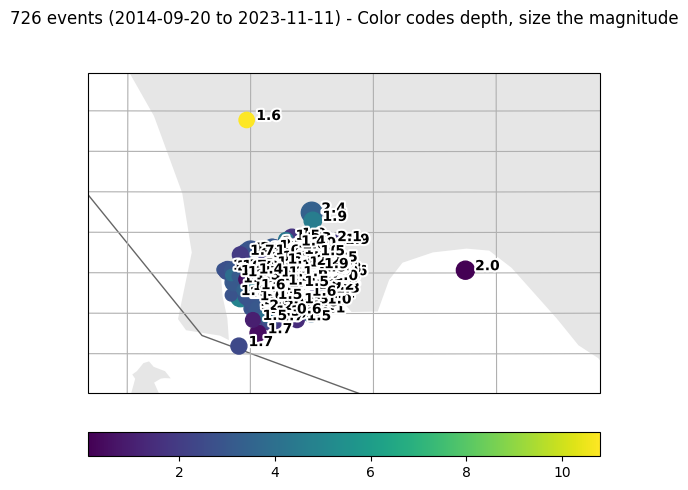

In [11]:
cat_manual.plot(projection='local',resolution='i');

In [38]:
cat_manual[700].picks[1].__dict__

{'resource_id': smi:webservices.ingv.it/fdsnws/event/1/query?pickId=416185421,
 'time': 2018-06-14T22:13:25.110000Z,
 'time_errors': QuantityError({'uncertainty': 0.1, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'waveform_id': WaveformStreamID
	  network_code: 'IV'
	  station_code: 'CPOZ'
	  channel_code: 'HHZ'
	 location_code: '',
 'filter_id': None,
 'method_id': smi:webservices.ingv.it/fdsnws/event/1/query?methodID=11,
 'horizontal_slowness': None,
 'horizontal_slowness_errors': None,
 'backazimuth': None,
 'backazimuth_errors': None,
 'slowness_method_id': None,
 'onset': 'questionable',
 'phase_hint': 'P',
 'polarity': 'undecidable',
 'evaluation_mode': 'manual',
 'evaluation_status': None,
 'creation_info': CreationInfo(agency_id='INGV ', author='BULLETIN-INGV', creation_time=UTCDateTime(2019, 2, 4, 18, 36, 19)),
 'comments': []}

### eliminate automatic picking from catalogue

In [35]:
for ev in cat_manual:
    len_pre=len(ev.picks)
    ind_picks=[]
    for ind,pick in enumerate(ev.picks):
        if pick.evaluation_mode == 'automatic':
            ind_picks.append(ind)
    
    for ind in reversed(ind_picks):
        del ev.picks[ind]
    len_post=len(ev.picks)
    if len_pre != len_post:
        print(len_pre,'-------',len_post)

some events have no picks (bad)

save catalogue

In [40]:
cat_manual.write('flegrei_2014_2023/catalogue_flegrei.xml',format='QUAKEML')

# INVENTORY

load catalogue from local

In [3]:
catf=read_events('flegrei_2014_2023/catalogue_flegrei.xml')

In [43]:
rad_stations=0.15
inv=client.get_stations(starttime=stime,endtime=etime,
                        latitude=lat,longitude=long,maxradius=rad_stations,
                        level='response')                                   #instrumental response

inv

Inventory created at 2023-11-18T18:33:08.147000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.57
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=2014-01-0...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (2):
			IV, IX
		Stations (19):
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CAFL (Arco Felice)
			IV.CAWE (Astroni Ovest - Stazione Osservatorio Vesuviano)
			IV.CBAC (Campi Flegrei, Castello di Baia - Stazione Osservatorio Vesu)
			IV.CCAP (Capo Posillipo C. acqisiz. - Stazione Osservatorio Vesuviano)
			IV.CFMN (Monte Nuovo)
			IV.CMIS (Faro di Capo Miseno - Stazione Osservatorio Vesuviano)
			IV.CMSN (Monte S.Angelo)
			IV.CMTS (Campi Flegrei, Via Metastasio CNR-IRC)
			IV.CNIS (Campi Flegrei - Isola di Nisida)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPIS (Campi Flegrei - Fumarola Pisciarelli)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CQUE (Campi Flegrei Qua

In [1]:
for station in inv.networks[0]:
    print(station.code)

NameError: name 'inv' is not defined

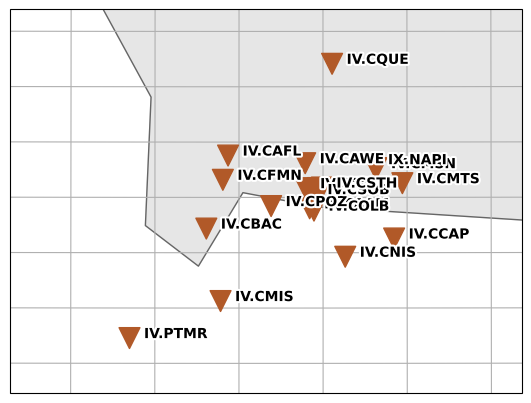

In [75]:
inv.plot(projection='local',resolution='h');

In [73]:
inv.write('flegrei_2014_2023/inventory_flegrei.xml',format='STATIONXML')                        #save

In [4]:
inv_f=read_inventory('flegrei_2014_2023/inventory_flegrei.xml')                                 #read

In [26]:
inv_f[0].stations[0]

Station CAAM (Accademia Aeronautica Pozzuoli)
	Station Code: CAAM
	Channel Count: 9/9 (Selected/Total)
	2011-12-09T23:00:00.000000Z - 
	Access: open 
	Latitude: 40.8201, Longitude: 14.1420, Elevation: 170.0 m
	Available Channels:
	    ..HN[ZNE]   200.0 Hz  2022-02-25 to None
	    ..HH[ZNE]   100.0 Hz  2022-02-25 to None
	    ..HH[ZNE]   100.0 Hz  2011-12-09 to 2022-02-25


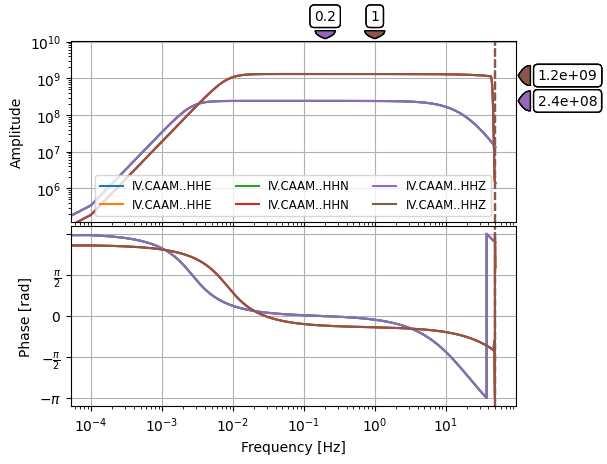

In [19]:
inv_f.plot_response(min_freq=1E-4,station='CAAM',channel='[EH]H?');

# WAVEFORMS

In [102]:
event_start=catf[-20].origins[0].time
event_end=catf[-20].origins[0].time +30

print('event occurred:',event_start)

wave=Stream()
for  station in inv_f.networks[0].stations:
    try:
        wave += client.get_waveforms(starttime=event_start,endtime=event_end,
                            network='IV',station=station.code,location='*', channel='EH?,HH?',
                            attach_response=True,)
    except:
        print(station.code , 'station not found')

print('traces found:',len(wave.traces))
wave

event occurred: 2018-03-12T14:39:41.000000Z
CAWE station not found
CCAP station not found
CMTS station not found
CNIS station not found
COLB station not found
CQUE station not found
CSTH station not found
PTMR station not found
traces found: 33


In [103]:
wave.traces[0].stats.sampling_rate

100.0

In [105]:
for tr in wave.traces:
    if tr.stats.sampling_rate == 200.:
        print('removing 200Hz trace from:',tr)
        wave.remove(tr)

In [16]:
wave.write('wave_f.mseed',format='MSEED')

/Users/user/Library/Python/3.9/lib/python/site-packages/obspy/io/mseed/core.py:821: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


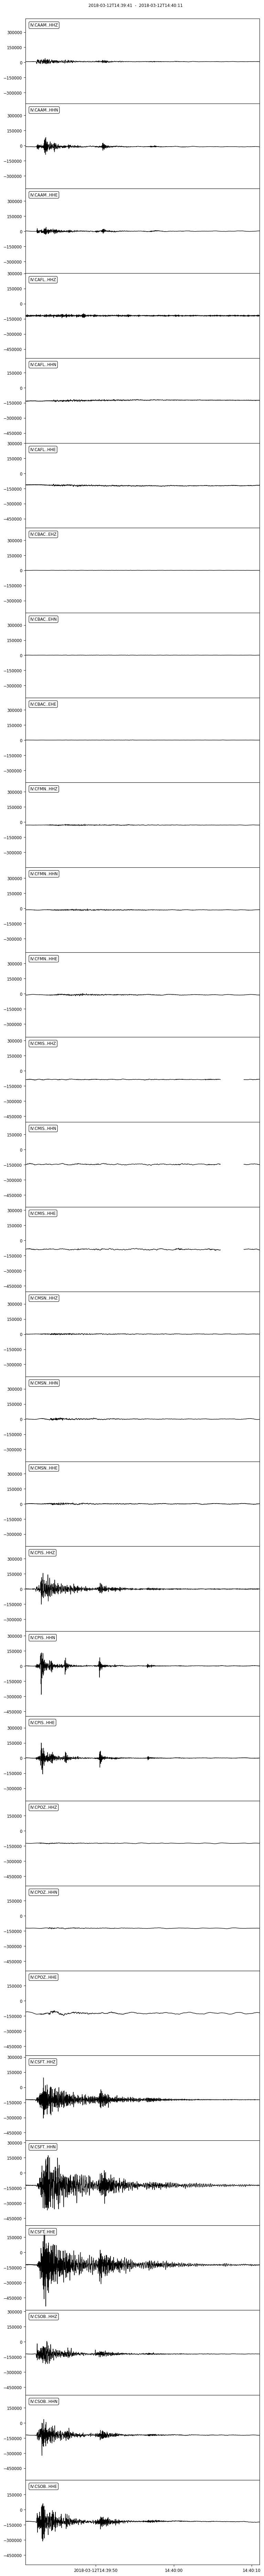

In [106]:
wave.plot();

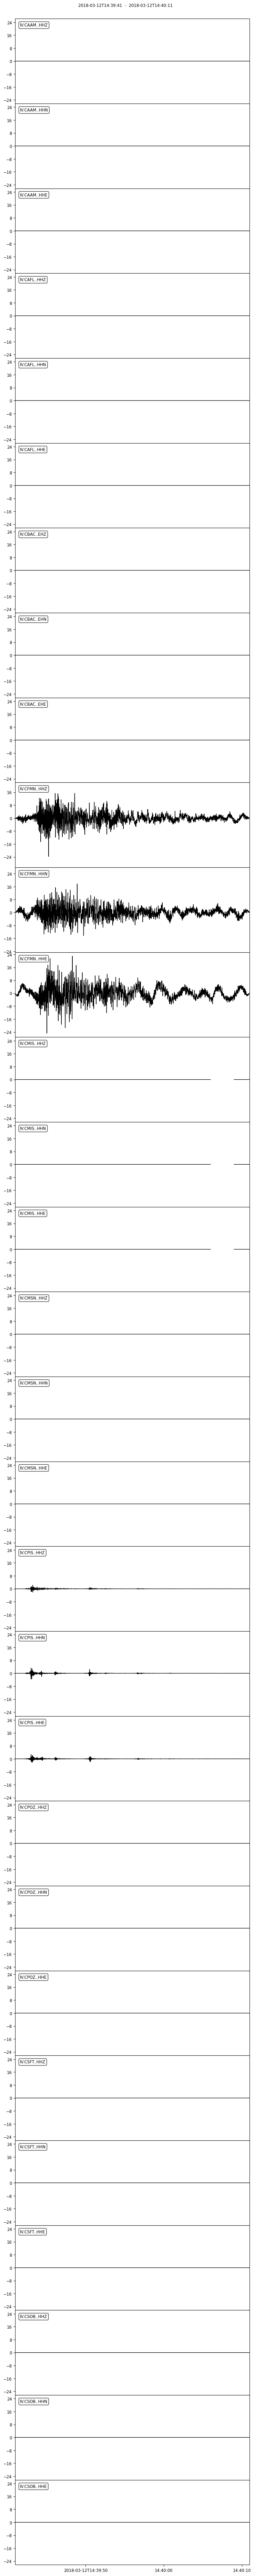

In [107]:
wave_response=copy.deepcopy(wave)
wave_response.remove_response(output="VEL")
wave_response.plot();